## Enunciado
Dado un proyecto con los datos que se muestran en la tabla siguiente, se pide:
   1. Dibujar el diagrama Pert y determinar el camino crítico.
   2. Probabilidad de terminar el proyecto antes de 9 periodos.
   3. Reducir la duración del proyecto hasta 10 periodos con el mínimo incremento posible de coste.
   4. Si el número máximo de recursos durante las 6 primeras semanas es 4, determinar si será posible realizar el proyecto en el tiempo obtenido en el apartado 1.

In [1]:
# Alargamos el ancho de las celdas al 100%
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

import pandas as pd
import numpy as np

datos_enunciado= pd.DataFrame([
#actividad, precedentes, duracion, desviacion,  cur, recursos, duracion_tope
  (   'A',     '--- ',       3,         2,        5,      1,       1  ),
  (   'B',     '--- ',       2,         1,        5,      1,       1  ),
  (   'C',     'B   ',       4,         2,       25,      1,       2  ),
  (   'D',     'A   ',       2,         1,      -10,      2,       1  ),
  (   'E',     'A   ',       4,         0,        1,      1,       4  ),
  (   'F',     'E   ',       3,         1,        5,      1,       2  ),
  (   'G',     'C,D ',       1,         0,      -20,      2,       1  ),
  (   'H',     'C,D ',       5,         3,        1,      1,       2  ),
  (   'I',     'F,G,H',      1,         0,        1,      1,       1  ),
  (   'J',     'F,G  ',      2,         0,       -1,      1,       2 ),
  (   'K',     'F,G  ',      1,         0,        5,      2,       1  ),
], columns=['actividad', 'precedentes', 'duracion', 'desviacion', 'cur', 'recursos', 'duracion_tope']).set_index('actividad')
datos_enunciado

,precedentes,duracion,desviacion,cur,recursos,duracion_tope
actividad,,,,,,
A,---,3,2,5,1,1
B,---,2,1,5,1,1
C,B,4,2,25,1,2
D,A,2,1,-10,2,1
E,A,4,0,1,1,4
F,E,3,1,5,1,2
G,"C,D",1,0,-20,2,1
H,"C,D",5,3,1,1,2
I,"F,G,H",1,0,1,1,1


## Solución
### Apartado 1
> Dibujar el diagrama Pert y determinar el camino crítico.

In [2]:
from pmule import GrafoProyecto

In [3]:
aristas = pd.DataFrame([
    ('A',  1, 2),
    ('B',  1, 3),
    ('C',  3, 5),
    ('D',  2, 5),
    ('E',  2, 4),
    ('F',  4, 6),
    ('G',  5, 6),
    ('H',  5, 7),
    ('I',  7, 9),
    ('J',  6, 9),
    ('K',  6, 8),
    ('f1', 6, 7),
    ('f2', 8, 9),
], columns=['actividad', 'nodo_inicial', 'nodo_final']).set_index('actividad')
aristas

,nodo_inicial,nodo_final
actividad,,
A,1,2
B,1,3
C,3,5
D,2,5
E,2,4
F,4,6
G,5,6
H,5,7
I,7,9


In [4]:
datos_proyecto = pd.concat([datos_enunciado, aristas], axis=1, sort=False).set_index(aristas.index).fillna(0)
datos_proyecto_apartado_1 = datos_proyecto.copy() # La necesitaremos en el apartado 4

In [5]:
proyecto = GrafoProyecto(datos_proyecto)

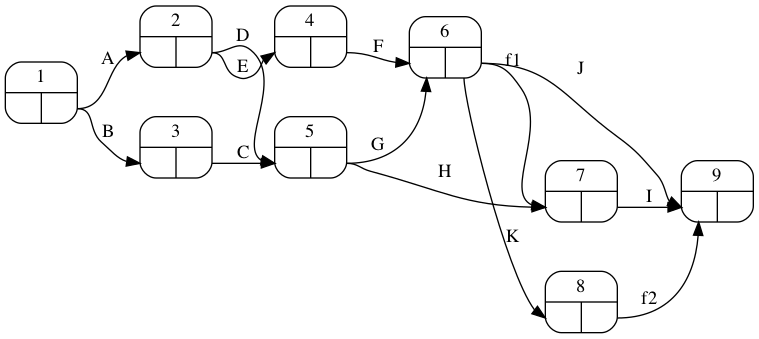

In [6]:
proyecto.pert(filename='pert_nodos_apartado_1.png',
              orientation='portrait', tiempos=False, ranksep=0.5, nodesep=0.5)

In [7]:
proyecto.zaderenko(duraciones=datos_proyecto['duracion'])

,1,2,3,4,5,6,7,8,9,temprano
1,,3,2,,,,,,,0
2,,,,4,2,,,,,3
3,,,,,4,,,,,2
4,,,,,,3,,,,7
5,,,,,,1,5,,,6
6,,,,,,,0,1,2,10
7,,,,,,,,,1,11
8,,,,,,,,,0,11
9,,,,,,,,,,12
tardios,0,3,2,7,6,10,11,12,12,


In [8]:
resultados_pert = proyecto.calcula_pert(duraciones=datos_proyecto['duracion'])
resultados_pert['tiempos']

,tempranos,tardios
1,0.0,0.0
3,2.0,2.0
2,3.0,3.0
4,7.0,7.0
5,6.0,6.0
6,10.0,10.0
7,11.0,11.0
8,11.0,12.0
9,12.0,12.0


In [9]:
resultados_pert['H_total']

A     0.0
B     0.0
D     1.0
E     0.0
C     0.0
F     0.0
G     3.0
H     0.0
J     0.0
K     1.0
f1    1.0
I     0.0
f2    1.0
dtype: float64

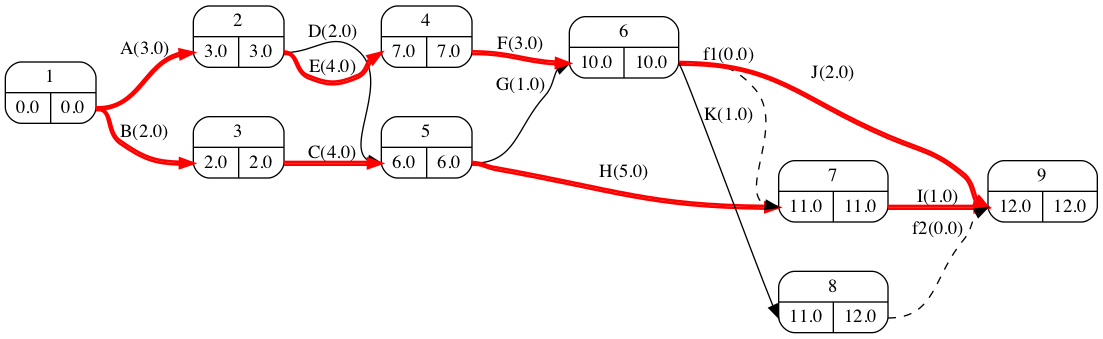

In [10]:
proyecto.pert(filename='pert_tiempos_apartado_1.png',
              duraciones=datos_proyecto['duracion'],
              orientation='portrait', tiempos=False, ranksep=0.5, nodesep=0.5)

In [11]:
proyecto.camino_critico(duraciones=datos_proyecto['duracion'])

Index(['A', 'B', 'E', 'C', 'F', 'H', 'J', 'I'], dtype='object')

## Apartado 2
> Probabilidad de terminar el proyecto antes de 9 periodos.

La duración media del proyecto la conocemos del apartado 1.

In [12]:
duracion_media_proyecto = proyecto.duracion_proyecto(duraciones=datos_proyecto['duracion'])
duracion_media_proyecto

12.0

Para determinar la desviación típica debemos obtener en cada rama del camino crítico la suma de las varianzas, y quedarnos con la mayor.

In [13]:
rama_AEFJ=['A', 'E', 'F', 'J']
rama_BCHI=['B', 'C', 'H', 'I']
varianza_AEFJ = (datos_proyecto.loc[rama_AEFJ, 'desviacion'] ** 2).sum()
varianza_BCHI = (datos_proyecto.loc[rama_BCHI, 'desviacion'] ** 2).sum()
print('rama_AEFJ:', varianza_AEFJ )
print('rama_BCHI:', varianza_BCHI )

rama_AEFJ: 5.0
rama_BCHI: 14.0


In [14]:
varianza_proyecto = max([varianza_AEFJ, varianza_BCHI])
desviacion_proyecto =  varianza_proyecto ** 0.5
desviacion_proyecto

3.7416573867739413

Una vez caracterizada la distribución normal con la que aproximamos la duración del proyecto, podemos hacer el cálculo de la probabilidad:

In [15]:
import scipy
from scipy.stats import norm

probabilidad = norm.cdf(9, loc=duracion_media_proyecto, scale=desviacion_proyecto)
probabilidad * 100

21.133903708531776

## Apartado 3
> Reducir la duración del proyecto hasta 10 periodos con el mínimo incremento posible de coste.

### Situación inicial de partida

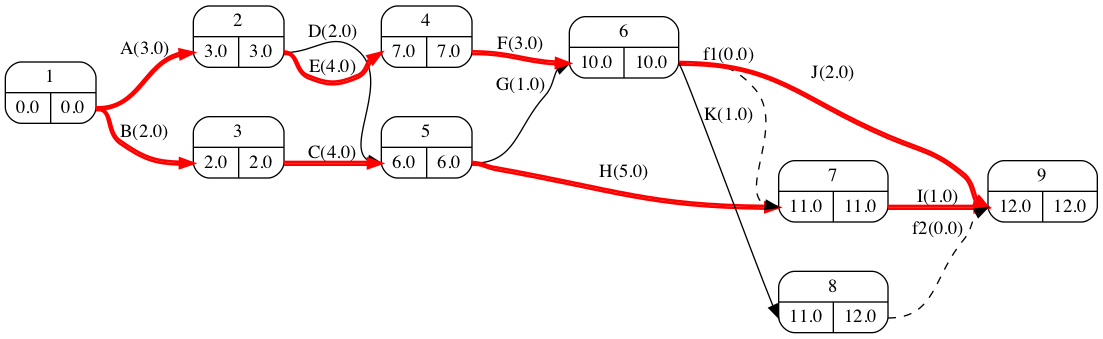

In [16]:
proyecto.pert(filename='pert_tiempos_apartado_3_situacion_inicial.png',
              duraciones=datos_proyecto['duracion'],
              orientation='portrait', tiempos=False, ranksep=0.5, nodesep=0.5)

### Primera reducción

Analizamos los costes unitarios de reducción y la capacidad de reducción de cada tarea de las ramas críticas:

In [17]:
datos_proyecto.loc[rama_AEFJ, ['cur', 'duracion', 'duracion_tope']].sort_values(by='cur')

,cur,duracion,duracion_tope
actividad,,,
J,-1.0,2.0,2.0
E,1.0,4.0,4.0
A,5.0,3.0,1.0
F,5.0,3.0,2.0


Para reducir la rama A E F J la tarea más conveniente es la J, pero no dispone deperiodos reducibles. La siguiente más conveniente es la E que tampoco es reducible. La siguiente más convenientees la A que sí es reducible y es la que se elige recortar.

In [18]:
datos_proyecto.loc[rama_BCHI, ['cur', 'duracion', 'duracion_tope']].sort_values(by='cur')

,cur,duracion,duracion_tope
actividad,,,
H,1.0,5.0,2.0
I,1.0,1.0,1.0
B,5.0,2.0,1.0
C,25.0,4.0,2.0


En la rama B C H I la tarea más conveniente es la H y es reducible.

Reducimos entonces 1 periodo las actividades A y H

In [19]:
datos_proyecto.loc[['A', 'H'], 'duracion'] -= 1

Con esta reducción el proyecto ya dura 11 periodos y no han surgidos nuevas ramas críticas.

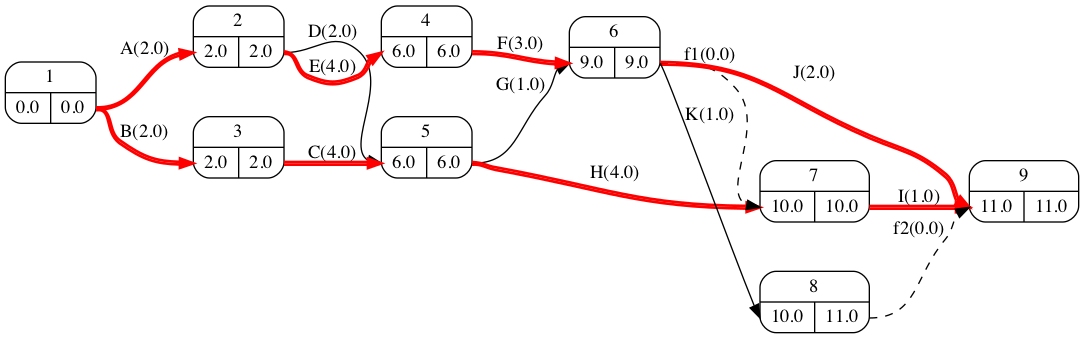

In [20]:
proyecto.pert(filename='pert_tiempos_apartado_3_situacion_11_periodos.png',
              duraciones=datos_proyecto['duracion'],
              orientation='portrait', tiempos=False, ranksep=0.5, nodesep=0.5)

### Segunda reducción

Analizamos nuevamente los costes unitarios de reducción y la capacidad de reducción de cada tarea de las ramas críticas:

In [21]:
datos_proyecto.loc[rama_AEFJ, ['cur', 'duracion', 'duracion_tope']].sort_values(by='cur')

,cur,duracion,duracion_tope
actividad,,,
J,-1.0,2.0,2.0
E,1.0,4.0,4.0
A,5.0,2.0,1.0
F,5.0,3.0,2.0


Para reducir la rama A E F J la tarea más conveniente de entre las reducibles es la A.

In [22]:
datos_proyecto.loc[rama_BCHI, ['cur', 'duracion', 'duracion_tope']].sort_values(by='cur')

,cur,duracion,duracion_tope
actividad,,,
H,1.0,4.0,2.0
I,1.0,1.0,1.0
B,5.0,2.0,1.0
C,25.0,4.0,2.0


En la rama B C H I la tarea más conveniente de entre las reducibles es la H.

Reducimos entonces 1 periodo las actividades A y H

In [23]:
datos_proyecto.loc[['A', 'H'], 'duracion'] -= 1

Con esta reducción el proyecto ya dura 10 periodos como nos pedían en el enunciado.

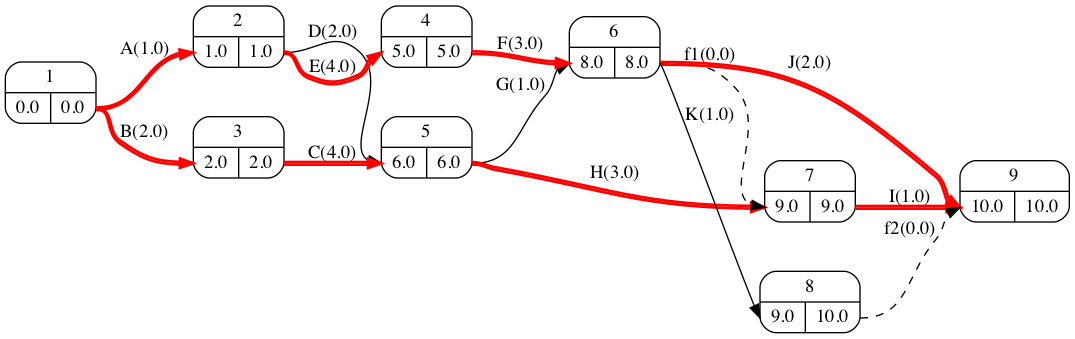

In [24]:
proyecto.pert(filename='pert_tiempos_apartado_3_situacion_10_periodos.png',
              duraciones=datos_proyecto['duracion'],
              orientation='portrait', tiempos=False, ranksep=0.5, nodesep=0.5)

El coste de la reducción ha sido:

In [25]:
2 * datos_proyecto.loc['A', 'cur'] + 2 * datos_proyecto.loc['H', 'cur']

12.0

## Apartado 4
> Si el número máximo de recursos durante las 6 primeras semanas es 4, determinar si será posible realizar el proyecto en el tiempo obtenido en el apartado 1.

Representamos la demanda de recursos por periodo utilizando un diagrama de Gantt.

In [26]:
proyecto.gantt(duraciones=datos_proyecto_apartado_1['duracion'],
               representar=datos_proyecto_apartado_1['recursos'],
               total='fila')

,1,2,3,4,5,6,7,8,9,10,11,12
A,1,1,1,,,,,,,,,
B,1,1,,,,,,,,,,
C,,,1,1,1,1,,,,,,
D,,,,2,2,,,,,,,
E,,,,1,1,1,1,,,,,
F,,,,,,,,1,1,1,,
G,,,,,,,2,,,,,
H,,,,,,,1,1,1,1,1,
I,,,,,,,,,,,,1
J,,,,,,,,,,,1,1


Se concluye por tanto que la restricción de recursos impuesta no implica ningún problema.